**If you think this notebook deserves an upvote, I'd love to have it. An upvote per view, its all I ask**
(credit to [Dan Carlin](https://twitter.com/HardcoreHistory) for coining the phrase ;-) 

---------------------------------------


This is part of a series of notebooks about practical time series methods:
* [Part 0: the basics](https://www.kaggle.com/konradb/ts-0-the-basics)
* [Part 1a: smoothing methods](https://www.kaggle.com/konradb/ts-1a-smoothing-methods)
* [Part 1b: Prophet](https://www.kaggle.com/konradb/ts-1b-prophet) 
* [Part 2: ARMA](https://www.kaggle.com/konradb/ts-2-arma-and-friends)
* [Part 3: Time series for finance](https://www.kaggle.com/konradb/ts-3-time-series-for-finance) 
* [Part 4: Sales and demand forecasting](https://www.kaggle.com/konradb/ts-4-sales-and-demand-forecasting)
* [Part 5: Automatic for the people](https://www.kaggle.com/code/konradb/ts-5-automatic-for-the-people) 
* [Part 6: Deep learning for TS - sequences](https://www.kaggle.com/konradb/ts-6-deep-learning-for-ts-sequences)
* [Part 7: Survival analysis](https://www.kaggle.com/konradb/ts-7-survival-analysis) - **this notebook**
* [Part 8: Hierarchical time series](https://www.kaggle.com/code/konradb/ts-8-hierarchical-time-series)
* [Part 9: Hybrid methods](https://www.kaggle.com/code/konradb/ts-9-hybrid-methods/)
* [Part 10: Validation methods for time series](https://www.kaggle.com/code/konradb/ts-10-validation-methods-for-time-series/)
* [Part 11: Transfer learning](https://www.kaggle.com/code/konradb/ts-11-deep-learning-for-ts-transfer-learning)


The series is accompanied by video presentations on the YouTube channel of [Abhishek](https://www.kaggle.com/abhishek):

* [Talk 0](https://www.youtube.com/watch?v=cKzXOOtOXYY) 
* [Talk 1](https://www.youtube.com/watch?v=kAI67Sz92-s) - combining the content from parts 1a and 1b
* [Talk 2](https://www.youtube.com/watch?v=LjV5DE3KR-U) 
* [Talk 3](https://www.youtube.com/watch?v=74rDhJexmTg)
* [Talk 4](https://www.youtube.com/watch?v=RdH8zd07u2E) 
* [Talk 5](https://www.youtube.com/watch?v=wBP8Pc4Wxzs) 
* [Talk 6](https://www.youtube.com/watch?v=81AEI0tj0Kk) 
* [Talk 7](https://www.youtube.com/watch?v=m-8I_hkmz9o) - **based on this notebook**
* [Talk 8](https://www.youtube.com/watch?v=7ZTarg4QYR4)
* [Talk 9](https://www.youtube.com/watch?v=NYZzBvKcfp4)
* [Talk 10](https://www.youtube.com/watch?v=47WeBiLV2Uo)
* [Talk 11]()


---------------------------------------

TL;DR Survival analysis should be a part of the toolbox of every data scientist - but unless you work in clinical research, it probably isn't. It originated in medical statistics (which is kind of evident from terminology), but the applications are way broader. In this episode we talk about when and why you should consider using survival analysis and show how to apply to different problems - including churn and customer lifetime value. We will be using `lifelines` - an excellent Python package bringing a vintage approach into modern ML.


* [Crash intro to survival analysis](#section-one)
* [Basic toolkit](#section-two)
* [Cox regression](#section-three)
* [Survival forest](#section-four)
* [Application: Customer Lifetime Value](#section-five)


In [1]:
! pip install lifelines

     |████████████████████████████████| 349 kB 596 kB/s            
     |████████████████████████████████| 77 kB 3.1 MB/s             
     |████████████████████████████████| 48 kB 3.4 MB/s             
  Preparing metadata (setup.py) ... - done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=6bb62f817548a4b4fac98ae182f4905318553653538de2f3676694fb798b42de
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.

In [2]:
!pip install lifetimes

     |████████████████████████████████| 584 kB 597 kB/s            


In [3]:
!pip install pysurvival

     |████████████████████████████████| 4.7 MB 580 kB/s            
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp37-cp37m-linux_x86_64.whl size=5329192 sha256=ff7a55a1567f73315cdf78b8074681bf0d6b5e09d0575d81674ef6263f18c4cf
  Stored in directory: /root/.cache/pip/wheels/1a/63/e2/32273d765a4e2f4ccac69c8adf97425ca80bab5d0c8447f120
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=b6dbdf40db2521c37fcf6a79f76c36121cc6b056e450c9d8f99041c1d10ddde2
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built pysurvival progressbar


In [4]:
import numpy as np
import pandas as pd
import os

import pandas_datareader as web

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)



In [5]:
class CFG:
    seed = 42    
    img_dim1 = 20
    img_dim2 = 10

    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   


We start with a theoretical intro and proceed with the well-trodden path for modeling: time-invariant $\rightarrow$ linear model $\rightarrow$ trees (and DL is possible ofc, but *outside the scope* of this notebook ;-) 

<a id="section-one"></a>
# Crash intro to survival analysis

So far we have mostly seen time series where we observed the past, we knew what happened / when - predictions are based on that info. That's not always the case:

**Q1**: Do we need to act before we observe all of the data?

**Q2**: Does time to event matter?

In [6]:
# rows / columns
list1 = ['P1', 'P2', 'P3', 'P4', 'P5']
list2 = ['2016','2017','2018','2019','2020','2021']
S = np.zeros((len(list1),len(list2)))
S = pd.DataFrame(S); S.index = list1; S.columns = list2

S.loc['P1'][['2019','2020','2021']] = 1
S.loc['P3'][['2018','2019','2020','2021']] = 1
S.loc['P4'][['2021']] = 1
S.loc['P5'][['2020','2021']] = 1

S = S.astype(int)

display(S)

,2016,2017,2018,2019,2020,2021
P1,0,0,0,1,1,1
P2,0,0,0,0,0,0
P3,0,0,1,1,1,1
P4,0,0,0,0,0,1
P5,0,0,0,0,1,1




2x YES $\implies$ use **survival analysis**:

- group of statistical methods dealing with time to event $\rightarrow$ **how long it takes for something of interest to happen**

- we have to close our observation window at some point to finalize our dataset and make decisions, 

- can’t  wait for all the data to roll in $\rightarrow$ some of our data will be censored

- some subjects will not yet have experienced the target event $\implies$ we know only that the time-to-event is at least some duration.

- outcome has both event and time value 

- survival models: prediction + causal inference

- probability distribution around events at / by / after a certain time 

- contribution of various factors on durations

- summary 1: quantify / visualise distribution of durations $\rightarrow$ expectations / baselines / thresholds 

- summary 2: survival curve for individual subjects $\rightarrow$ prioritize interventions

Different use cases where survival analysis might be the right approach are listed below ([source](https://odsc.medium.com/when-to-use-survival-analysis-applications-in-industry-data-science-d8bfb7566f43) ):

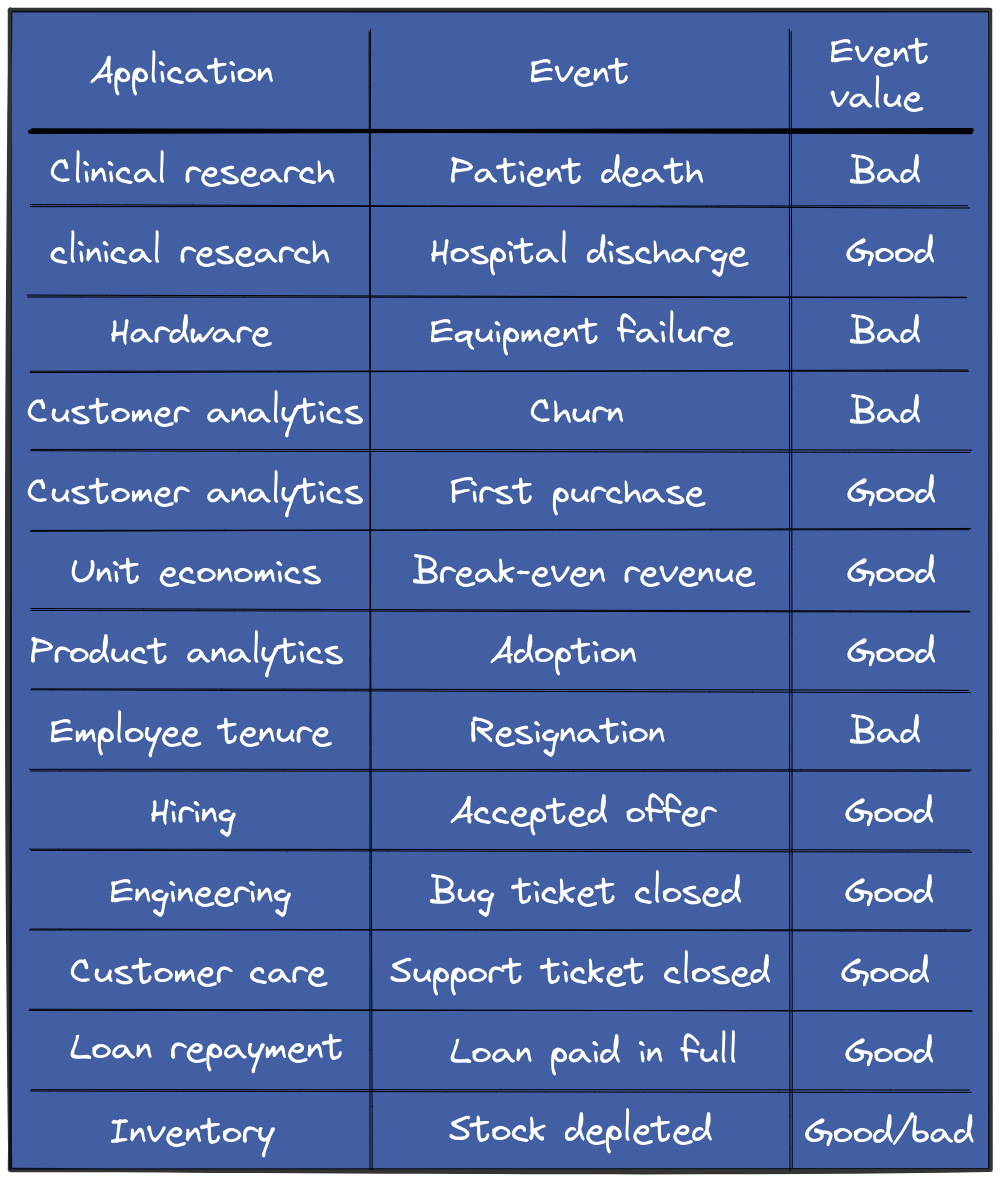


<a id="section-two"></a>
# Basic toolkit

We need three main bulding blocks to start applying survival analysis: 

- the random variable $T$ representing the time of event of interest

- survival function $S_t$ - probability of an event taking place later than time $t$

- hazard function $h_t$ - instantaneous risk

We discuss them briefly below

## Time of event 

- We start with the random variable representing the time of the event of interest $T$ (see above).

- continuous random variable: $[0, \infty)$ $\rightarrow$ $[0,1]$

In graphical form ([source](https://towardsdatascience.com/practical-survival-analysis-concepts-techniques-models-10819fd49b4a)):

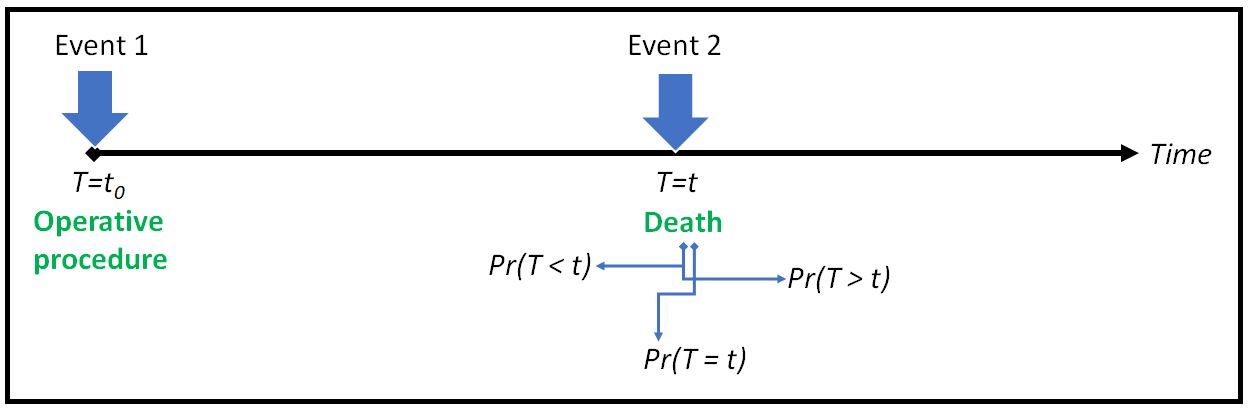

So far so good - but what makes survival analysis special is **censoring**: $\sim$ `NA` of survival analysis. Observations are censored when the information about their survival time is incomplete:

- we don't know what could've happened after the observation period, but the absence of event is informative about the risk 

- censored observations contribute to the total risk  

There are 3 types of censoring: right, left and interval censoring:

### Right censoring 


The most common type of censoring: occurs when the survival time is incomplete at the end of the observation period

[source](https://towardsdatascience.com/introduction-to-survival-analysis-6f7e19c31d96) 

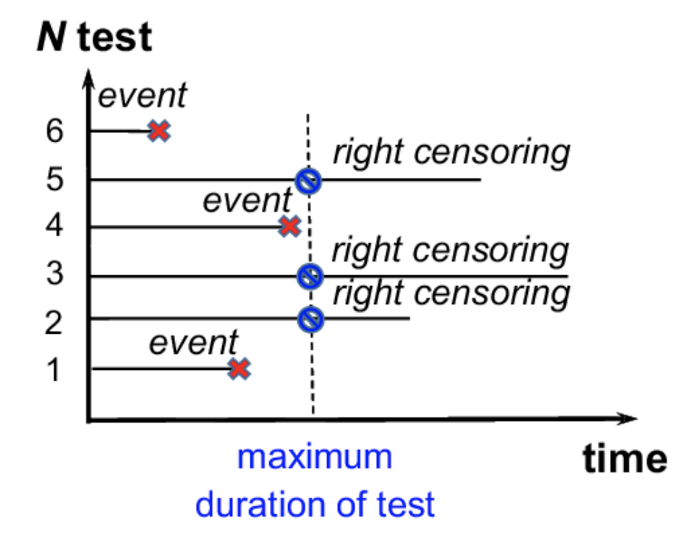

### Left censoring 

Left-censoring occurs when we cannot observe the time when the event occurred

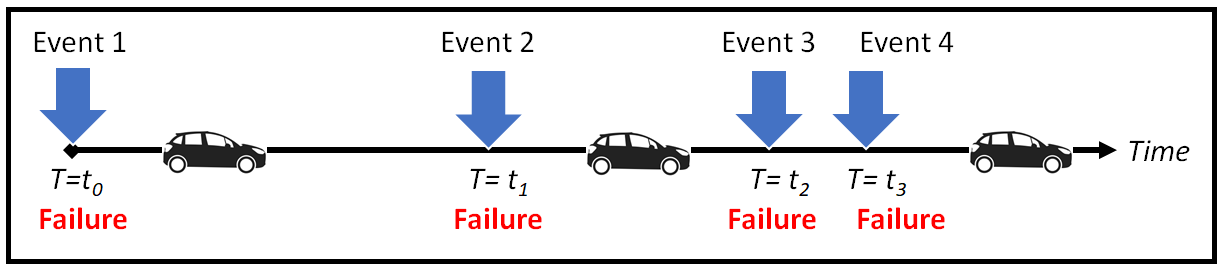

### Interval Censoring
We performed testing at $t_1$ and $t_2$ - negative outcome first, positive second $\rightarrow$ we only now the event happened at some point between $t_1$ and $t_2$

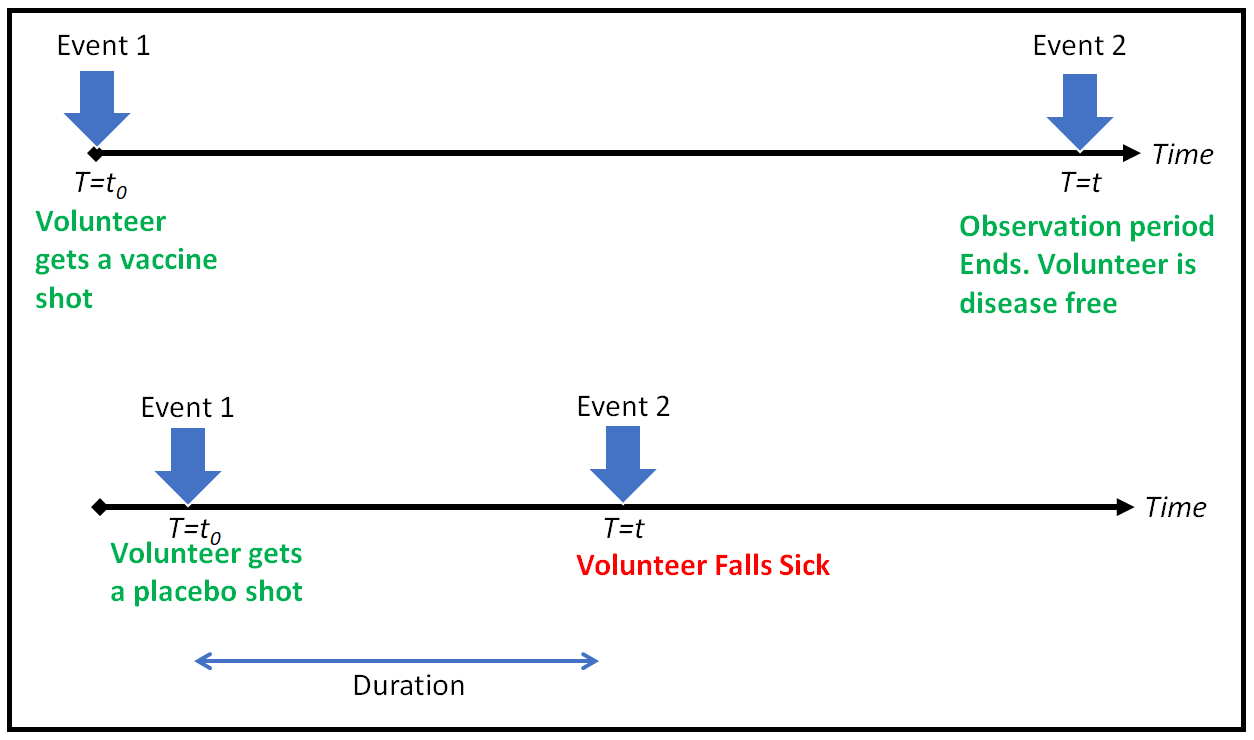


- RC prevents OLS-type methods usage $\rightarrow$ errors are unknown

- quick fixes can introduce bias 



A good summary of different types of censoring is given in the [Wikipedia](https://en.wikipedia.org/wiki/Survival_analysis#Censoring) article. 


## Survival function 

Survival function is given by 

\begin{equation}
S(t) = P(T > t)
\end{equation}

Interpretation: probability of the event of interest **not occurring** by time $t$.



Survival estimation comes in three flavours: 

1. parametric: survival times follow specific probability distribution $\rightarrow$ Weibull, exponential, lognormal4

2. semi-parametric: Cox regression (see below)

3. non-parametric: survival probabilities $\sim$ time $\rightarrow$ **Kaplan-Meier**


## KM estimator

Kaplan-Meier estimator:

- non-parametric estimate of the survival function

- non-negative regression + density estimation of a single random variable in the presence of censoring 

- break the estimation into steps depending on observed event times 

\begin{equation}
\hat{S}(t) = \prod_{i: t_i \leq t} \left(1 - \frac{d_i}{n_i} \right)
\end{equation}

where $n_i$ is a number of individuals who are at risk at time point $t_i$ and $d_i$ is a number of subjects that experienced the event at time $t_i$.


Assuming you are still here after the - necessary! - theoretical introduction, let's see what we can do about applying survival analysis to a churn dataset (Kaggle Dataset: https://www.kaggle.com/datasets/blastchar/telco-customer-churn).



In [7]:
df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df['churn'] = [1 if x == 'Yes' else 0 for x in df['Churn']]
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.5,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1


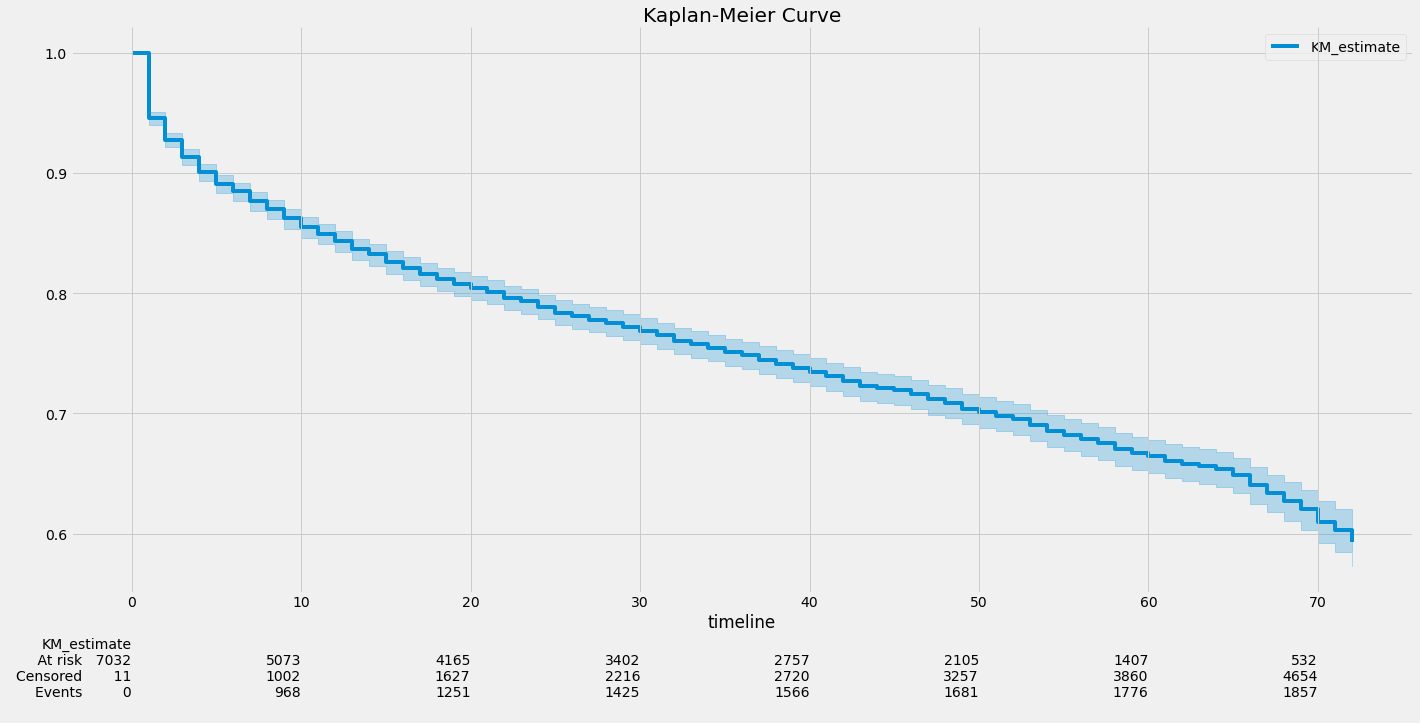

In [8]:
# we only need time-to-event and the churn flag for the basic model
from lifelines import KaplanMeierFitter 

T = df['tenure'] # months
E = df['churn']

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

kmf.plot(at_risk_counts=True)
plt.title('Kaplan-Meier Curve');


Kaplan-Meier estimate can be used like this to get a general idea over the population:

- estimated $\hat{S}$ is a stepwise function of overall population 
 
- x axis: tenure in months, y axis: probability the customer has **not** churned up that point in time

- confidence bands: [Greenwood’s exponential formula](https://www.stat.berkeley.edu/~freedman/greenwd.pdf)

What if we'd like to get more insight into behaviour per subset of the population (= level of a categorical feature)?

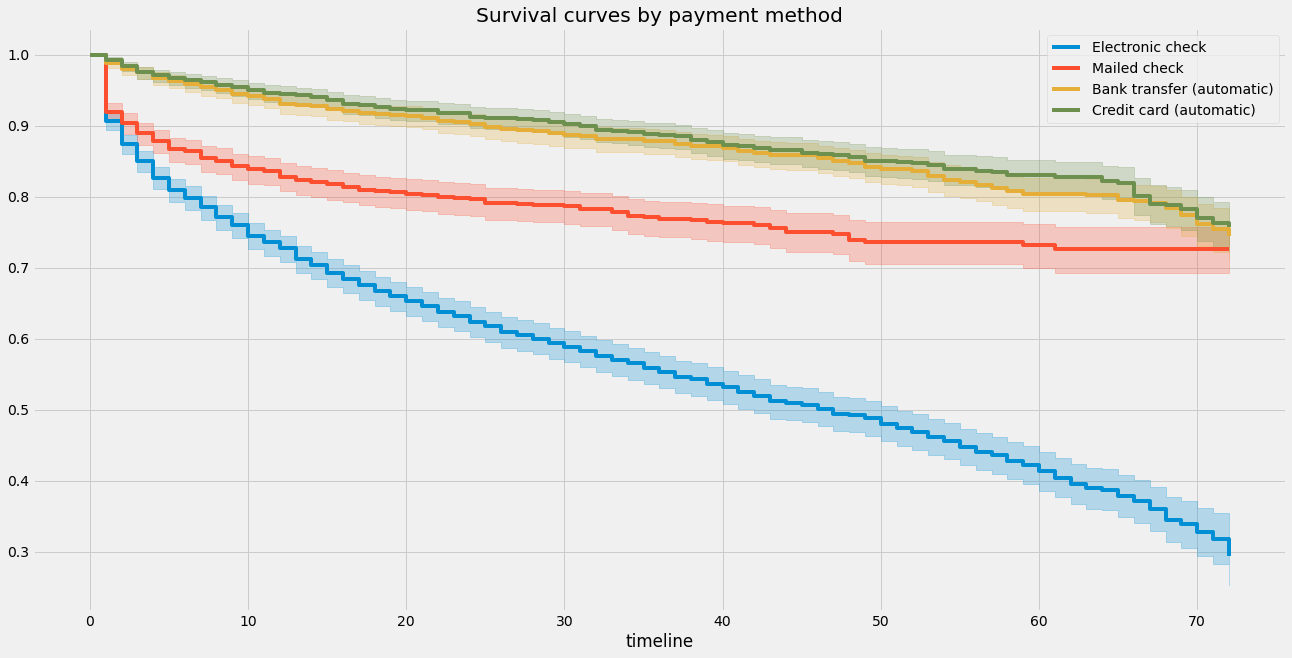

In [9]:
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for payment_method in df['PaymentMethod'].unique():
    
    flag = df['PaymentMethod'] == payment_method
    
    kmf.fit(T[flag], event_observed = E[flag], label = payment_method)
    kmf.plot(ax=ax)

plt.title("Survival curves by payment method");

While quite simple, Kaplan-Meier estimator allows us to address EDA-type questions - for example, we can test whether two groups have different survival characteristics (using the [logrank test](https://en.wikipedia.org/wiki/Logrank_test)):

In [10]:
from lifelines.statistics import logrank_test, pairwise_logrank_test


credit_card_flag = df['PaymentMethod'] == 'Credit card (automatic)'
bank_transfer_flag = df['PaymentMethod'] == 'Bank transfer (automatic)'

results = logrank_test(T[credit_card_flag], 
                       T[bank_transfer_flag], 
                       E[credit_card_flag], 
                       E[bank_transfer_flag])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.87 0.35      1.51

No reason to reject the null (survival curves being identical). What about comparing all the combinations?

In [11]:
results = pairwise_logrank_test(df['tenure'], df['PaymentMethod'], df['churn'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                                                   test_statistic      p  -log2(p)
Bank transfer (automatic) Credit card (automatic)            0.87   0.35      1.51
                          Electronic check                 510.04 <0.005    372.74
                          Mailed check                      51.07 <0.005     40.03
Credit card (automatic)   Electronic check                 539.74 <0.005    394.21
                          Mailed check                      64.82 <0.005     50.11
Electronic check          Mailed check                     152.46 <0.005    113.93

K-M summary: 
    
- (+) flexible, minimal assumptions

- (+) fast

- (-) no covariates incorporation $\rightarrow$ prediction :-( 

- (-) not smooth 


Can we do better? 

**Hazard function**:

\begin{equation}
\lambda(t) = -\frac{S^{'}(t)}{S(t)}
\end{equation}

**Cumulative hazard rate**:

\begin{equation}
\Lambda(t) = \int_0^t \lambda(s) ds = -\log S(t)
\end{equation}

Nelson-Aalen estimator for the cumulative hazard rate :

\begin{equation}
\hat{\lambda}(t) = \sum_{i: t_i \leq t} \frac{d_i}{n_i}
\end{equation}

- less popular due to interpretation

- useful as building block e.g. for Cox regression

- measures total amount of risk accumulated $\le t$

- intuition: expected events if non-absorbing (death + resurrection, failure + fix)

Using `lifelines` :


Text(0.5, 1.0, 'Cumulative hazard function')

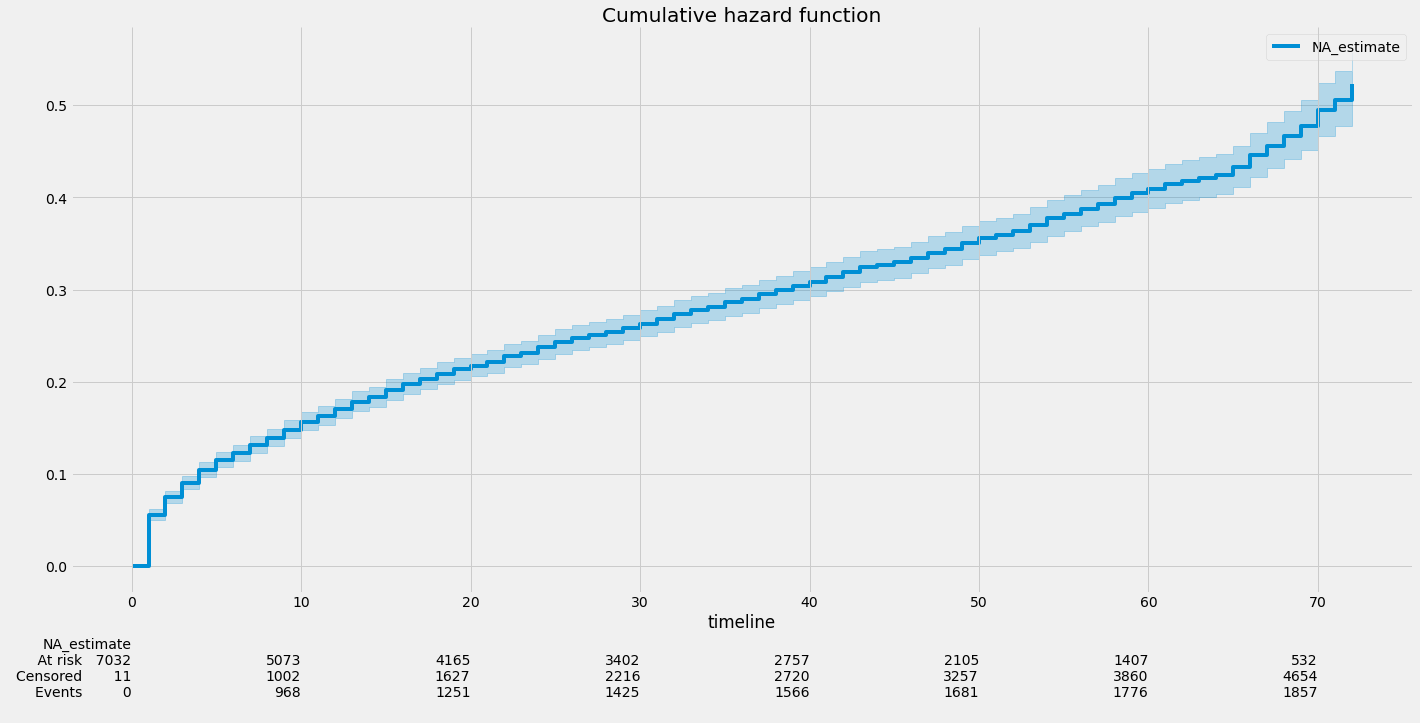

In [12]:
from lifelines import NelsonAalenFitter

naf = NelsonAalenFitter()
naf.fit(T, event_observed=E)

naf.plot(at_risk_counts=True)
plt.title('Cumulative hazard function')

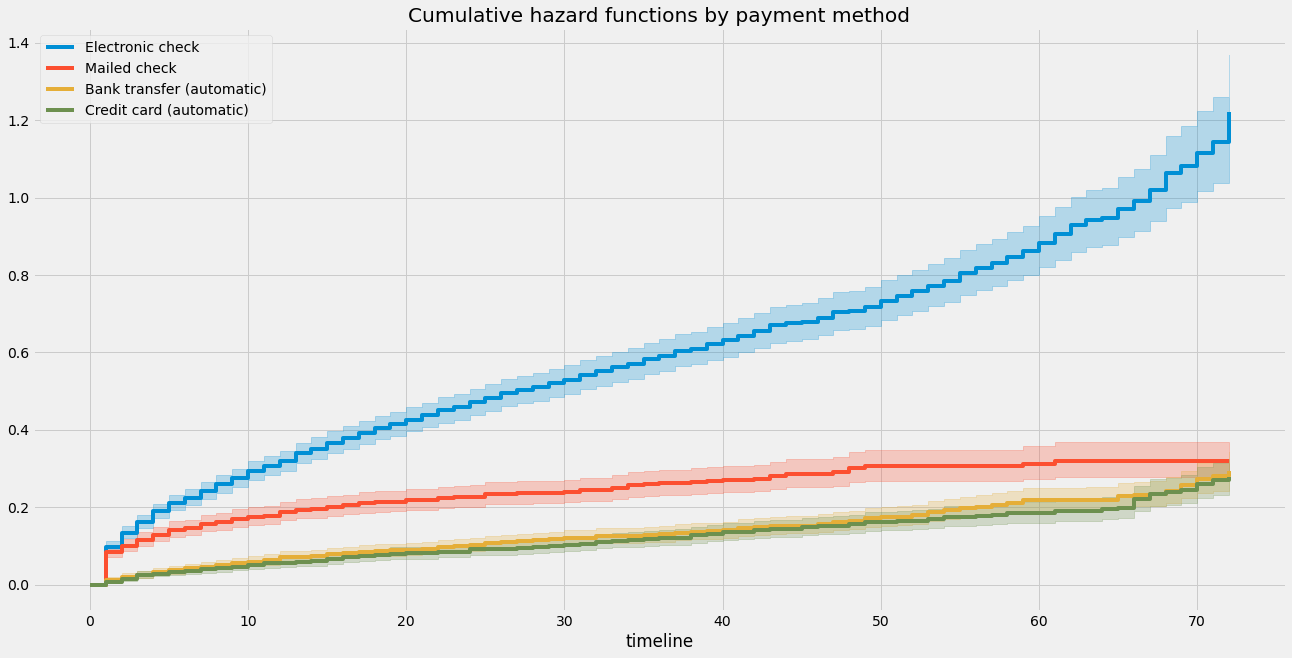

In [13]:
ax = plt.subplot(111)

naf = NelsonAalenFitter()

for payment_method in df['PaymentMethod'].unique():
    
    flag = df['PaymentMethod'] == payment_method
    
    naf.fit(T[flag], event_observed=E[flag], label=payment_method)
    naf.plot(ax=ax)

plt.title('Cumulative hazard functions by payment method');

<a id="section-three"></a>
# Cox regression

Cox proportional is defined by a hazard rate relationship:

\begin{equation}
\lambda(t) = \lambda_0(t) \exp \left( X^T \beta \right)
\end{equation} 


- covariates have a multiplying effect on the hazard rate

- effect is constant over time 

- population-level baseline hazard $\lambda_0$ is time invariant

- failure times are (conditionally) independent

- $\lambda_0(t)$ - baseline hazard 

- coefficient signs $\rightarrow$ comonotone

- works with right-censored data

In [14]:
# process the data for Cox model
id_col = df['customerID']; df.drop(['customerID', 'TotalCharges'], axis = 1, inplace = True)
df = df[['gender', 'SeniorCitizen', 'Partner','tenure', 'churn', 'PhoneService', 'OnlineSecurity', 'Contract']]
df = pd.get_dummies(df, drop_first = True)

# split into training and test
df_train, df_test =  df.iloc[:-10], df.iloc[-10:]

from lifelines import CoxPHFitter

cph = CoxPHFitter()

cph.fit(df_train, duration_col='tenure', event_col='churn')


<lifelines.CoxPHFitter: fitted with 7033 total observations, 5166 right-censored observations>

Performance of a Cox model $\rightarrow$ Concordance index = for a survival model C-index $\approx$ weighted average of the area under time-specific ROC. 

Intuition: 

- C-index measure discrimination power

- only evaluates the rank: does model predict same order of churn as really happened?

- not impacted by value (duration)

- necessary evil for right-censored data


In [15]:
cph.print_summary(columns=["coef","exp(coef)","exp(coef) lower 95%","exp(coef) upper 95%", "z", "p"], decimals=3)

<lifelines.CoxPHFitter: fitted with 7033 total observations, 5166 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 7033
number of events observed = 1867
   partial log-likelihood = -14141.867
         time fit was run = 2022-09-30 12:27:47 UTC

---
                                     coef  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%       z       p
covariate                                                                                                     
SeniorCitizen                      -0.034      0.966                0.869                1.075  -0.633   0.527
gender_Male                        -0.056      0.945                0.863                1.035  -1.218   0.223
Partner_Yes                        -0.615      0.541                0.490                0.596 -12.341 <0.0005
PhoneService_Yes                    0.169      1.184                1.011                1.388   2.092   0.036
OnlineSecurity_No internet service -0.747      0.474                0.389                0.577  -7.411 <0.0005
OnlineSecurity_Yes                 -0.786      0.456                0.401                0.518 -12.026 <0.0005
Contract_One year                  -1.966      0.140                0.118                0.165 -23.072 <0.0005
Contract_Two year                  -3.774      0.023                0.017                0.031 -23.470 <0.0005
---
Concordance = 0.829
Partial AIC = 28299.733
log-likelihood ratio test = 2985.035 on 8 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

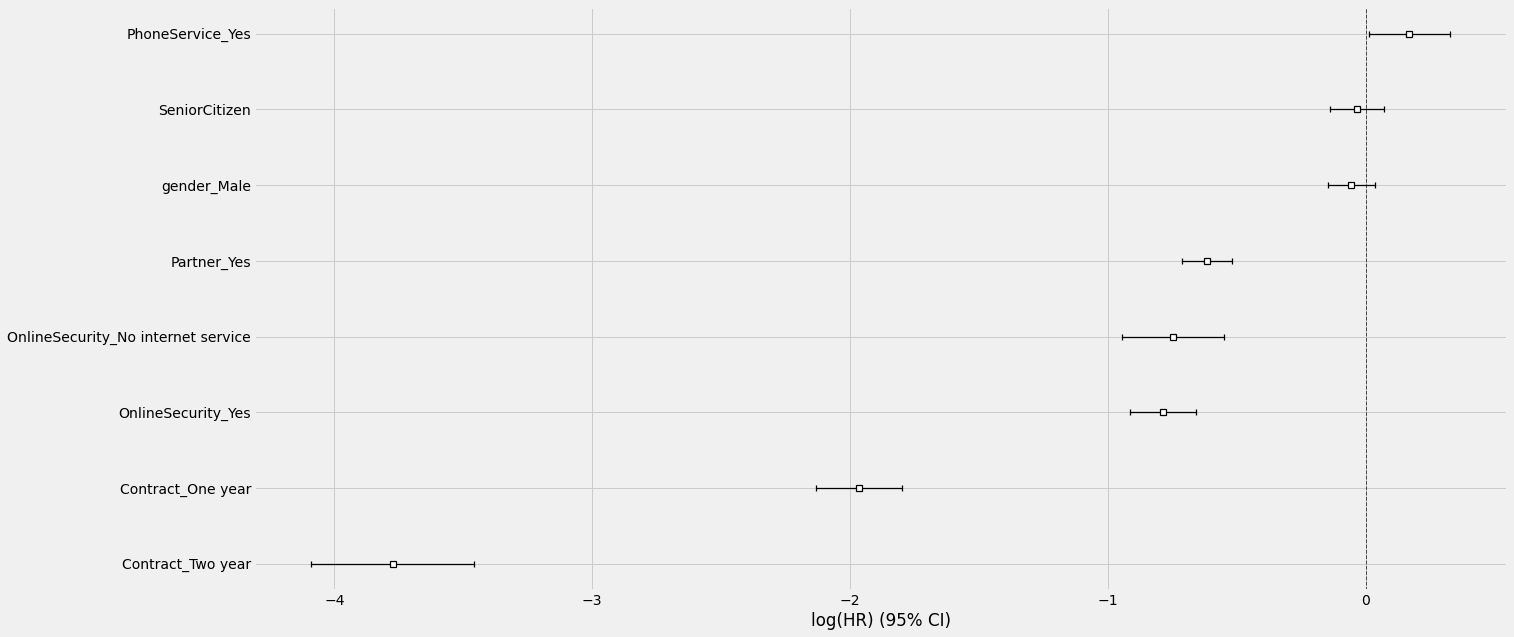

In [16]:
# Lets plot the individual risk factors

cph.plot()

Cox model produces predictions of individual survival curves:

In [17]:
cph.predict_survival_function(df_test)

,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042
0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1.0,0.873556,0.936883,0.873556,0.983238,0.998446,0.995348,0.989235,0.970676,0.931816,0.998586
2.0,0.828889,0.913465,0.828889,0.976805,0.997843,0.993548,0.985087,0.959523,0.906614,0.998038
3.0,0.793657,0.894529,0.793657,0.971514,0.997344,0.992060,0.981667,0.950391,0.886274,0.997584
4.0,0.762054,0.877169,0.762054,0.966590,0.996878,0.990671,0.978478,0.941926,0.867659,0.997160
...,...,...,...,...,...,...,...,...,...,...
68.0,0.029101,0.181620,0.029101,0.642557,0.960121,0.885149,0.753378,0.458987,0.157595,0.963662
69.0,0.018944,0.147654,0.018944,0.608972,0.955390,0.872138,0.727923,0.417591,0.125934,0.959343
70.0,0.008402,0.099758,0.008402,0.550100,0.946494,0.848020,0.682047,0.349148,0.082354,0.951215
71.0,0.004505,0.073856,0.004505,0.508849,0.939730,0.829981,0.648844,0.304374,0.059465,0.945030


<AxesSubplot:>

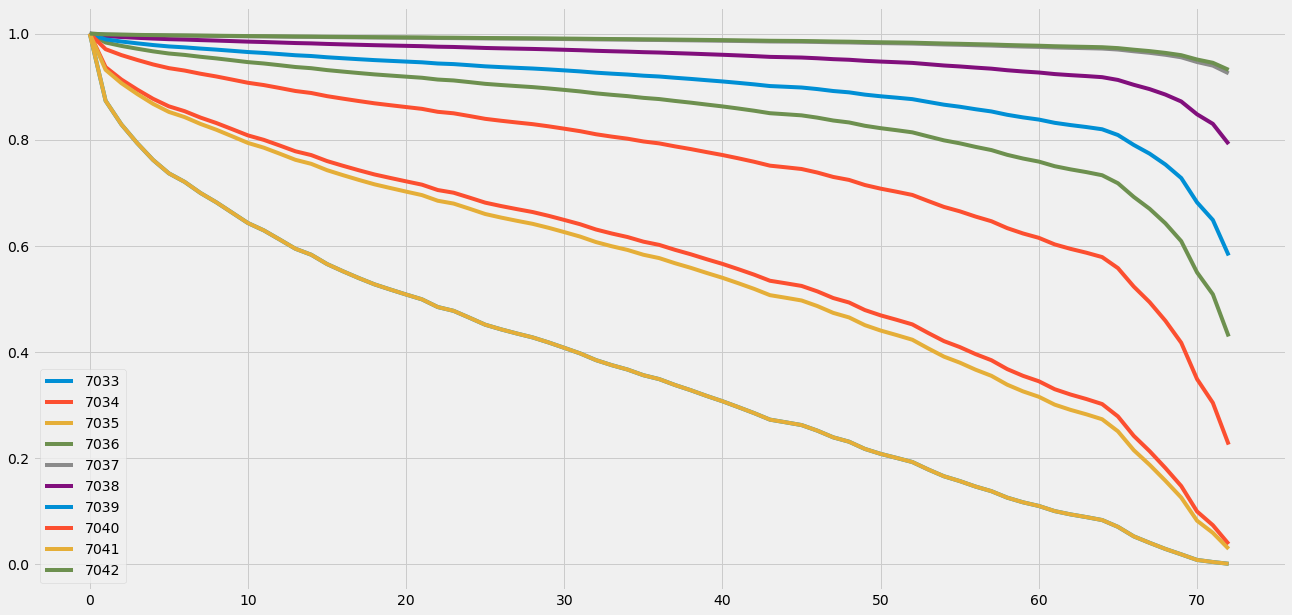

In [18]:
cph.predict_survival_function(df_test).plot()

We can also zoom in on the diagnostics:

<AxesSubplot:>

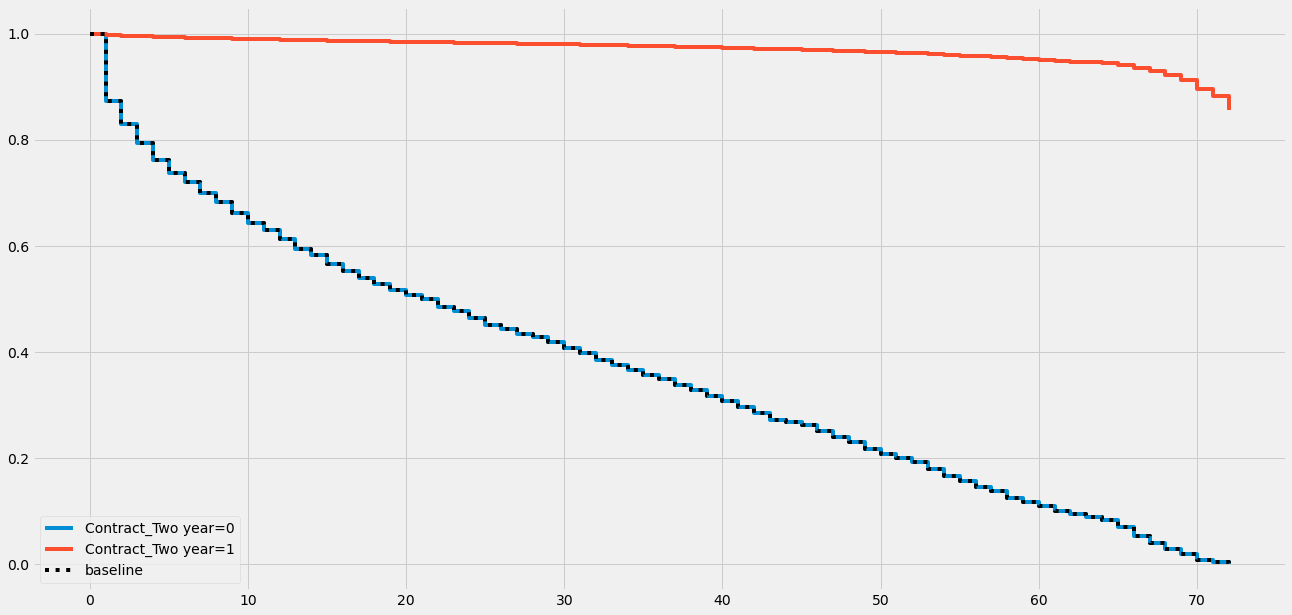

In [19]:
cph.plot_partial_effects_on_outcome(covariates='Contract_Two year', values = [0,1])


<a id="section-four"></a>
# Survival forest

We started with a simple nonparametric estimator of the survival function, moved to hazard rate and then a (log)linear model for the latter. What's the logical next step? Trees - more precisely, random forest + survival analysis = **conditional survival forest**.

- extra difficulty compared to RF: data is censored

- `ConditionalSurvivalForestModel` handles it by adding the event column (is it censored)

- time vector $T = min(t, c)$  where t denotes the event time and c the time of censoring

- survival models predict the probability that the event of interest will happen at time t.


In [20]:
from pysurvival.datasets import Dataset
from pysurvival.utils.display import correlation_matrix, compare_to_actual,    integrated_brier_score, create_risk_groups

from pysurvival.utils.metrics import concordance_index      
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel


In [21]:
features = [f for f in df_train.columns if f not in ['tenure', 'churn']]

time_column = 'tenure'
event_column = 'churn'


df_train, df_test =  df.iloc[:-10], df.iloc[-10:]


X_train, X_test = df_train[features], df_test[features]
T_train, T_test = df_train[time_column], df_test[time_column]       # when did the Churn event occur?
E_train, E_test = df_train[event_column], df_test[event_column]     # did the Churn event occur?

Fit the model:

In [22]:
# fitting a survival forest model
model = ConditionalSurvivalForestModel(num_trees=200)
model.fit(
        X_train, 
        T_train, 
        E_train, 
        max_features="sqrt",   
        max_depth=3,            
        min_node_size=20,      
        alpha=0.05,             
        seed=42, 
        sample_size_pct=0.63,   
        num_threads=-1          
        )

ConditionalSurvivalForestModel

concordance index: 0.93


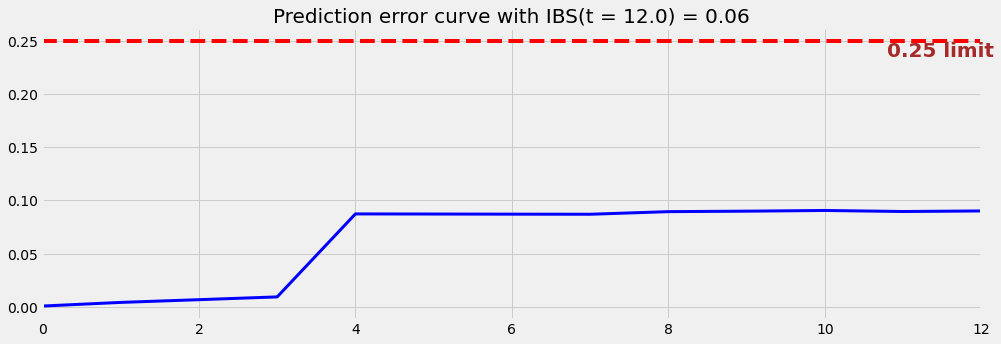

integrated Brier score: 0.06


In [23]:
# testing: model quality - prediction error measures by concordance index and Brier score

ci = concordance_index(model, X_test, T_test, E_test)
print("concordance index: {:.2f}".format(ci))

ibs = integrated_brier_score(model, X_test, T_test, E_test, t_max=12, figure_size=(15,5))
print("integrated Brier score: {:.2f}".format(ibs))

We talked about concordance score before, so a few words on Brier: the **Brier score** measures the average discrepancy between the actual churn status and the estimated probability: the average squared distance between the observed survival status (0 or 1) and the survival probability at a given time t. It can assume values between 0 and 1, with 0 being the optimal value: the survival function would perfectly predict the survival status (Brier Score).

`PySurvival` method `compare_to_actual` method plots the predicted and the actual number of customers at risk along the time axis. It also computes three accuracy metrics, the RMSE, MAE, and median absolute error. Internally, it calculates the Kaplan-Meier estimator to determine the actual survival function of the source data.

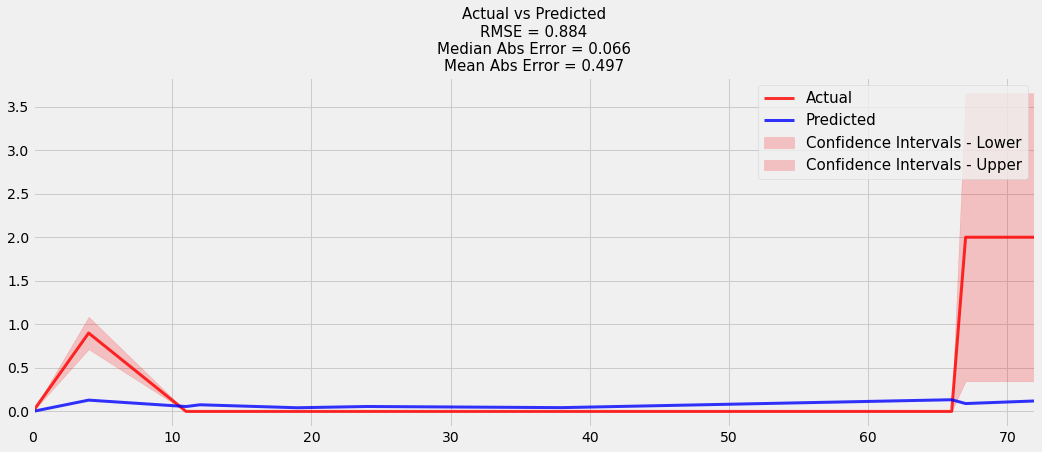

accuracy metrics:
root_mean_squared_error : 0.88
median_absolute_error : 0.07
mean_absolute_error : 0.50


In [24]:

res = compare_to_actual(
            model, 
            X_test, 
            T_test, 
            E_test,
            is_at_risk = False,       
            figure_size=(16, 6),
            metrics = ["rmse", "mean", "median"])   
print("accuracy metrics:")
_ = [print(k,":",f'{v:.2f}') for k,v in res.items()]

<a id="section-five"></a>
# Application: CLV

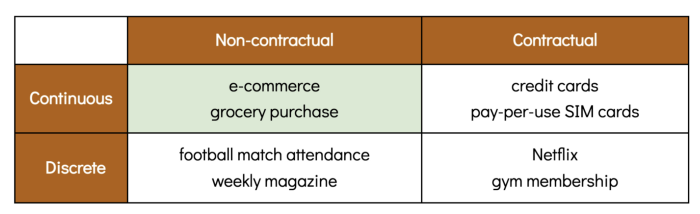

Not all customers are equally valuable: [source](https://towardsdatascience.com/modeling-customer-lifetime-value-with-lifetimes-71171a35f654)

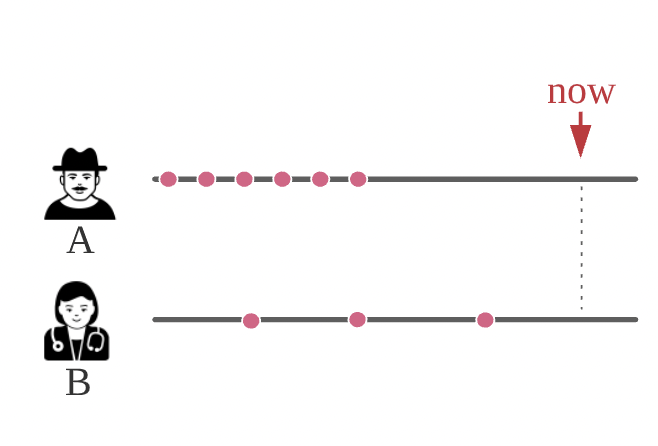

Assumptions:

- we focus on customers who did actually purchase successfully

- churn is **permanent** and **latent** 

Combining the information on both the temporal patterns for customers and the value of their purchases can be handled in different manners - we will use the BG-NBD: **B**eta-**G**eometric **N**egative **B**inomial **D**istribution. For a proper description please read this excellent post on Medium: https://towardsdatascience.com/customer-lifetime-value-estimation-via-probabilistic-modeling-d5111cb52dd; the original paper is worth a read as well http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf.




TL;DR version:

- CLV in a period = predicted transactions x predicted value of each purchase

- BG-NBD focuses on the transactions dynamic - purchase rates very per customer

- number of transactions: Poisson process

- time between: exponential distribution

- variation in buying behaviour: Gamma distribution

- churn: geometric distribution

- churn variation: Beta distribution

- RFM format for the data: **R**ecency, **F**requency, **M**onetary value

We will demonstrate this approach using data from the [Elo Merchant Category Recommendation](https://www.kaggle.com/competitions/elo-merchant-category-recommendation) competition.


In [25]:
df1 = pd.read_csv('../input/elo-merchant-category-recommendation/historical_transactions.csv',
                  nrows = 500000,
                 usecols = ['card_id','purchase_date','purchase_amount'])
df1['purchase_date'] = pd.to_datetime(df1['purchase_date'])
df1.head(5)

,card_id,purchase_amount,purchase_date
0,C_ID_4e6213e9bc,-0.703331,2017-06-25 15:33:07
1,C_ID_4e6213e9bc,-0.733128,2017-07-15 12:10:45
2,C_ID_4e6213e9bc,-0.720386,2017-08-09 22:04:29
3,C_ID_4e6213e9bc,-0.735352,2017-09-02 10:06:26
4,C_ID_4e6213e9bc,-0.722865,2017-03-10 01:14:19


In [26]:
df1.purchase_date.describe()

count                  500000
unique                 480174
top       2017-11-24 00:00:00
freq                      441
first     2017-01-01 00:46:31
last      2018-02-28 23:43:23
Name: purchase_date, dtype: object

In [27]:
from lifetimes.utils import summary_data_from_transaction_data

# format to RFM format
rfm = summary_data_from_transaction_data(transactions = df1,
                                         customer_id_col='card_id',
                                         datetime_col='purchase_date',
                                         monetary_value_col = 'purchase_amount',                                         
                                         freq='D')

rfm.head(3)

,frequency,recency,T,monetary_value
card_id,,,,
C_ID_002198cdf1,51.0,176.0,195.0,-1.189117
C_ID_0032aebb26,150.0,241.0,242.0,-1.659501
C_ID_003839dd44,159.0,403.0,408.0,-0.940783


One of the handy utilities in `lifetimes` is a calibration-holdout split: 

In [28]:

from lifetimes.utils import calibration_and_holdout_data

rfm_cal_holdout = calibration_and_holdout_data(transactions=df1,
                                                customer_id_col='card_id',
                                             datetime_col='purchase_date',
                                             monetary_value_col = 'purchase_amount',                                         
                                             freq='D',
                                                calibration_period_end='2017-12-31',
                                               observation_period_end='2018-02-28' )

rfm_cal_holdout.head(3)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
card_id,,,,,,,
C_ID_002198cdf1,32.0,135.0,136.0,-1.165039,19.0,-0.648992,59.0
C_ID_0032aebb26,111.0,173.0,183.0,-1.571031,39.0,-0.716737,59.0
C_ID_003839dd44,135.0,348.0,349.0,-0.912989,24.0,-0.692921,59.0


In [29]:
# fit the model
from lifetimes import BetaGeoFitter


bgf = BetaGeoFitter(penalizer_coef = 0.9)

bgf.fit(frequency=rfm_cal_holdout['frequency_cal'], 
        recency=rfm_cal_holdout['recency_cal'], 
        T=rfm_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 2399 subjects, a: 0.01, alpha: 1.54, b: 0.19, r: 0.53>

Evaluating the diagnostics? Easy

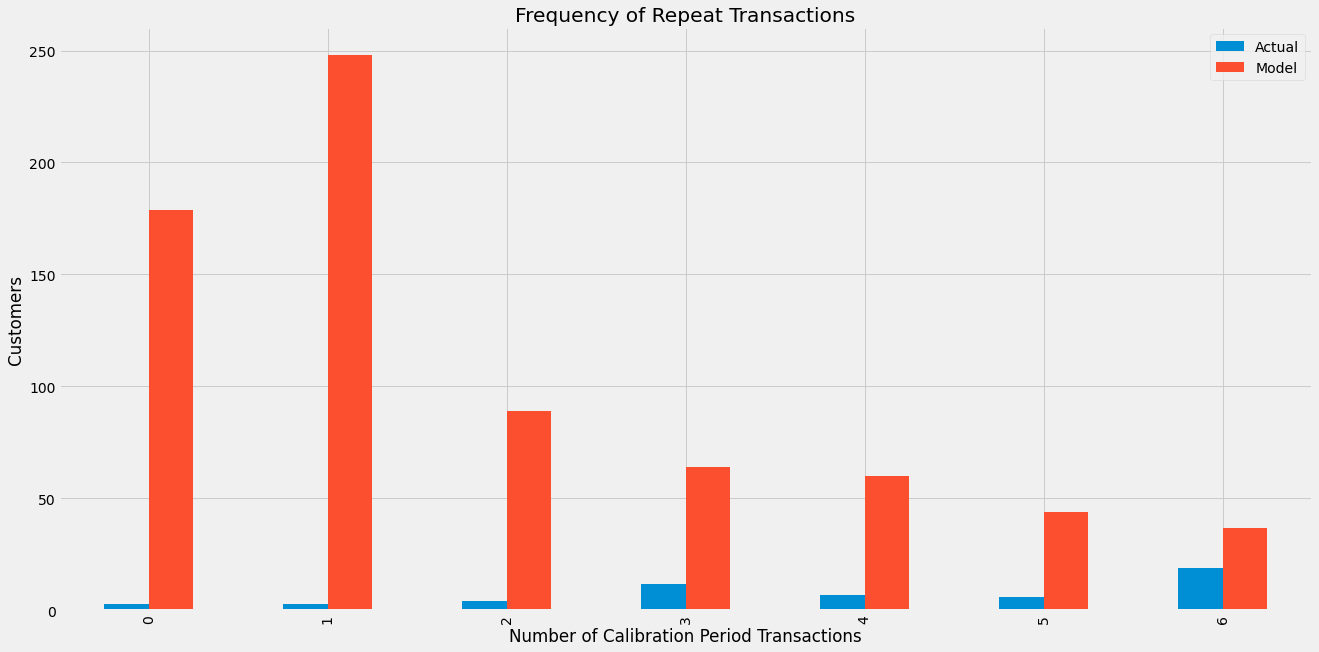

In [30]:

from lifetimes.plotting import plot_period_transactions

_ = plot_period_transactions(bgf) 


Predictions:

In [31]:
sample_customer = rfm_cal_holdout.iloc[13] 

# Let's inspect his frequency, recency and T both for the calibration and observation periods:
sample_customer

frequency_cal              68.000000
recency_cal               280.000000
T_cal                     296.000000
monetary_value_cal         -1.571509
frequency_holdout           5.000000
monetary_value_holdout     -0.729487
duration_holdout           59.000000
Name: C_ID_01b098ff01, dtype: float64

In [32]:
n_transactions_pred = bgf.predict(t= 60, 
                                  frequency=sample_customer['frequency_cal'], 
                                  recency=sample_customer['recency_cal'], 
                                  T=sample_customer['T_cal'])

n_transactions_pred 

13.68081350614679